In [54]:
import matplotlib.pyplot as plt
import numpy as np
import classy

from astropy.cosmology import Planck18_arXiv_v2 as Planck

kmax = 500

h = Planck.h
class LCDM:
    h = h
    H0 = Planck.H0.value
    omega_b = Planck.Ob0 * h ** 2
    omega_cdm = (Planck.Om0 - Planck.Ob0) * h ** 2
    omega_nu = Planck.Onu0
    omega_k = Planck.Ok0

    m_ncdm = sum(Planck.m_nu).value
    Neff = Planck.Neff
    N_ncdm = 1
    N_ur = Planck.Neff - N_ncdm

    Tcmb = Planck.Tcmb0.value
    A_s = 2.097e-9
    tau_reio = 0.0540
    n_s = 0.9652
    YHe = 0.24537116583825905
    reion_exponent = 1.5
    reion_width = 0.5

    @classmethod
    def class_params(self):
        return {
            'h': self.h, 'omega_b': self.omega_b, 'omega_cdm': self.omega_cdm,
            'Omega_k': self.omega_k, 'N_ur': self.N_ur, 'N_ncdm': self.N_ncdm,
            'm_ncdm': self.m_ncdm, 'A_s': self.A_s, 'n_s': self.n_s,
            'T_cmb': self.Tcmb, 'tau_reio': self.tau_reio, 'YHe': self.YHe,
            'reionization_exponent': self.reion_exponent,
            'reionization_width': self.reion_width, 'P_k_max_1/Mpc': kmax,
            'output': 'dTk,mPk,tCl',
        }



In [78]:
m_dmeff = 1.0e-3  # GeV
sigma_dmeff = 1e-41  # cm^2
# sigma_dmeff = 1e-40
Vrel_dmeff = 30 # km/s at z ~ 1010

z_pk = 60.

params_lcdm = LCDM.class_params()
params_lcdm.update({'z_pk': z_pk})

params_idm = dict(params_lcdm)
params_idm.update({
    'omega_dmeff': 0.12038, 'omega_cdm': 1e-10, 'm_dmeff': m_dmeff,
    'sigma_dmeff': sigma_dmeff, 'npow_dmeff': -4, 'Vrel_dmeff': Vrel_dmeff
})


cl_lcdm = classy.Class()
cl_lcdm.set(params_lcdm)
cl_lcdm.compute()

cl_idm = classy.Class()
cl_idm.set(params_idm)
cl_idm.compute()


In [79]:
import pyccl as ccl


cosmo_lcdm = ccl.Cosmology(Omega_c=params_lcdm['omega_cdm'], 
                      Omega_b=params_lcdm['omega_b'],
                      h=params_lcdm['h'],
                      n_s=params_lcdm['n_s'], A_s=params_lcdm['A_s'])

cosmo_idm = ccl.Cosmology(Omega_c=params_idm['omega_dmeff'], 
                      Omega_b=params_idm['omega_b'],
                      h=params_idm['h'],
                      n_s=params_idm['n_s'], A_s=params_idm['A_s'])

# adapting from here: https://github.com/damonge/ShCl_like/blob/0350b0cca5de51cd92efb8e27be292bbbb449bce/shcl_like/clccl.py#L141

z_bg = np.concatenate((np.linspace(0, 10, 100), np.geomspace(10, 1500, 50)))
z_pk = np.linspace(0., 20., 64)

k_arr = np.logspace(-5, np.log10(kmax), 1000)

def set_cosmo_arrays(cosmo, cl, z_bg=z_bg, kmax=kmax, k_arr=k_arr, z_pk=z_pk):
    """Sets background and power arrays in cosmo using Class instance
    """
    a = 1/(1 + z_bg[::-1])
    distance = cl.z_of_r(z_bg)
    distance = np.flip(distance)

    hubble_z = np.array([cl.Hubble(z) for z in z_bg])
    H0 = hubble_z[0]
    E_of_z = hubble_z / H0
    E_of_z = np.flip(E_of_z)

    class_pk_lin = cl.get_pk_array(k_arr, z_pk, 1000, 64, False).reshape([64, 1000])[::-1, :]

    cosmo._set_background_from_arrays(a_array=a, chi_array=distance, hoh0_array=E_of_z)
    cosmo._set_linear_power_from_arrays(1./(1 + z_pk[::-1]), k_arr, class_pk_lin)
    
    return class_pk_lin
    
pk_lin_lcdm = set_cosmo_arrays(cosmo_lcdm, cl_lcdm)
pk_lin_idm = set_cosmo_arrays(cosmo_idm, cl_idm)
    
# compute HMF                                                                                                                                                                                                      
mdef = ccl.halos.MassDef(500, 'critical')

hmf_lcdm = ccl.halos.MassFuncTinker08(cosmo_lcdm, mass_def=mdef)
hmf_idm = ccl.halos.MassFuncTinker08(cosmo_idm, mass_def=mdef)

In [80]:
import numpy as np
Mgrid = np.logspace(6, 12, 100)

def z_to_a(z):
    return 1 / (1 + z)

dndm_lcdm = hmf_lcdm.get_mass_function(cosmo_lcdm, Mgrid, z_to_a(60))
dndm_idm = hmf_idm.get_mass_function(cosmo_idm, Mgrid, z_to_a(60))

In [81]:
pk_lin_lcdm.shape

(64, 1000)

In [82]:
z_pk

array([ 0.        ,  0.31746032,  0.63492063,  0.95238095,  1.26984127,
        1.58730159,  1.9047619 ,  2.22222222,  2.53968254,  2.85714286,
        3.17460317,  3.49206349,  3.80952381,  4.12698413,  4.44444444,
        4.76190476,  5.07936508,  5.3968254 ,  5.71428571,  6.03174603,
        6.34920635,  6.66666667,  6.98412698,  7.3015873 ,  7.61904762,
        7.93650794,  8.25396825,  8.57142857,  8.88888889,  9.20634921,
        9.52380952,  9.84126984, 10.15873016, 10.47619048, 10.79365079,
       11.11111111, 11.42857143, 11.74603175, 12.06349206, 12.38095238,
       12.6984127 , 13.01587302, 13.33333333, 13.65079365, 13.96825397,
       14.28571429, 14.6031746 , 14.92063492, 15.23809524, 15.55555556,
       15.87301587, 16.19047619, 16.50793651, 16.82539683, 17.14285714,
       17.46031746, 17.77777778, 18.0952381 , 18.41269841, 18.73015873,
       19.04761905, 19.36507937, 19.68253968, 20.        ])

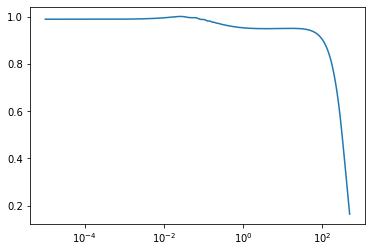

In [83]:
import matplotlib.pyplot as plt

plt.semilogx(k_arr, pk_lin_idm[-1, :]/pk_lin_lcdm[-1, :])

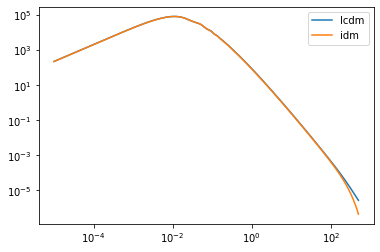

In [65]:
plt.loglog(k_arr, pk_lin_lcdm[-1, :], label='lcdm')
plt.loglog(k_arr, pk_lin_idm[-1, :], label='idm')
plt.legend()

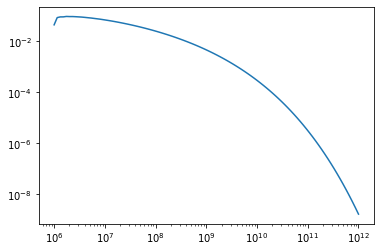

In [34]:
import matplotlib.pyplot as plt

# plt.loglog(Mgrid, dndm_lcdm)
# plt.loglog(Mgrid, dndm_idm)
plt.loglog(Mgrid, dndm_idm/dndm_lcdm)